In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import plotly.express as px

In [2]:
# чтение файла
df = pd.read_csv('data/М.Тех_Данные_к_ТЗ_DS.csv',  encoding='Windows-1251')
df.head()

,"Количество больничных дней,""Возраст"",""Пол"""
0,"5,39,""Ж"""
1,"4,54,""М"""
2,"4,26,""М"""
3,"5,42,""М"""
4,"4,29,""М"""


In [3]:
# Приведение таблицы в нормальный вид
df[['Количество больничных дней','Возраст','Пол']]\
                            = df['Количество больничных дней,"Возраст","Пол"'].str.split(',', expand=True)
df.drop('Количество больничных дней,"Возраст","Пол"', axis=1, inplace=True)
df.head()

,Количество больничных дней,Возраст,Пол
0,5,39,"""Ж"""
1,4,54,"""М"""
2,4,26,"""М"""
3,5,42,"""М"""
4,4,29,"""М"""


In [4]:
# проверка типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Количество больничных дней  237 non-null    object
 1   Возраст                     237 non-null    object
 2   Пол                         237 non-null    object
dtypes: object(3)
memory usage: 5.7+ KB


Можно заметить, что количественные значения иметь категориальный тип данных, поэтому необходимы соответсвующие преобразования

In [5]:
# приведение в числовой формат колонок: Возраст, Количество больничных дней
df['Количество больничных дней'] = df['Количество больничных дней'].astype(np.int32)
df['Возраст'] = df['Возраст'].astype(np.int32)

In [6]:
# проверка данных на наличие пропусков, выбросов
df.describe()

,Количество больничных дней,Возраст
count,237.000000,237.000000
mean,3.257384,40.181435
std,1.807821,6.875157
min,0.000000,23.000000
25%,2.000000,36.000000
50%,3.000000,41.000000
75%,4.000000,45.000000
max,8.000000,60.000000


In [7]:
# Удостоверились, что данные действительно преобразовались
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Количество больничных дней  237 non-null    int32 
 1   Возраст                     237 non-null    int32 
 2   Пол                         237 non-null    object
dtypes: int32(2), object(1)
memory usage: 3.8+ KB


### Визуализация данных

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

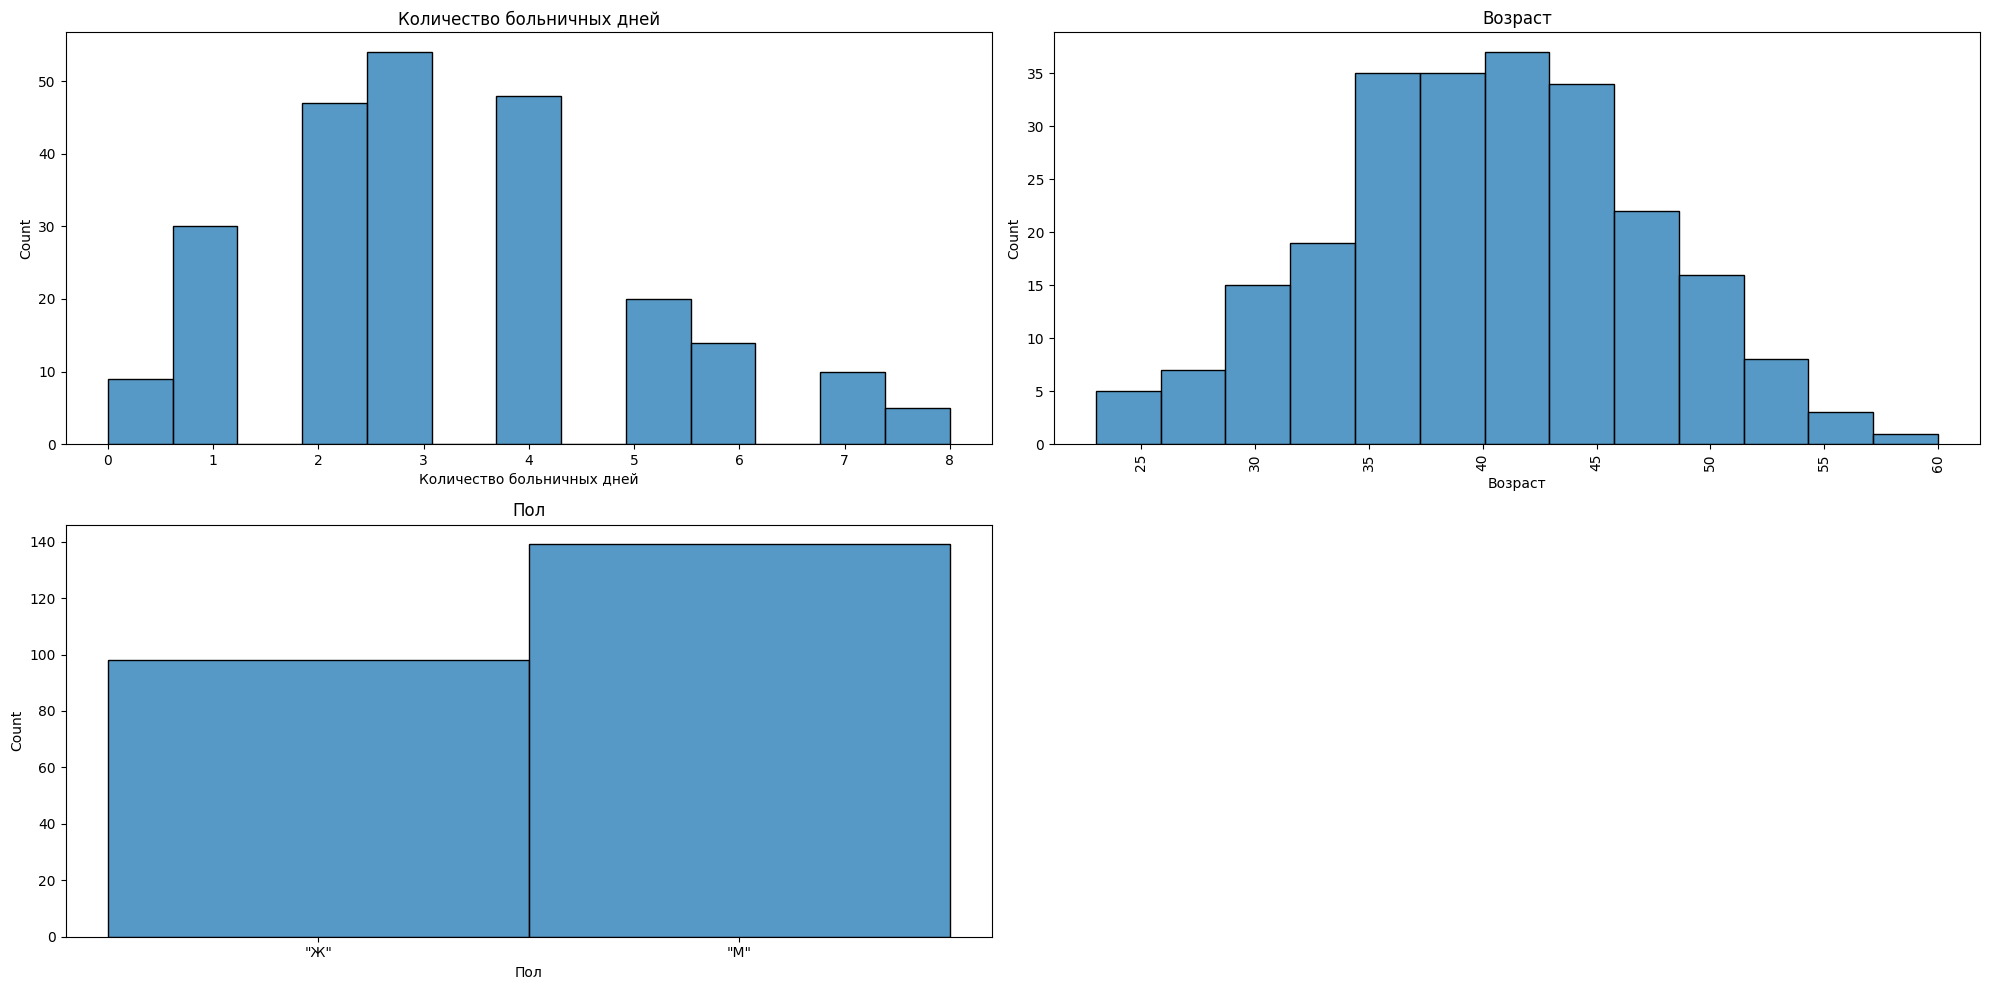

In [9]:
plt.figure(figsize=(20,10))
for i, col in enumerate(df.columns):
    plt.subplot(2, 2, i+1)
    if col == 'Возраст':
        plt.xticks(rotation=90,)
    plt.title(col)
    sns.histplot(df[col])
plt.tight_layout()

*По результатам первичного анализа проблемы в данных **не обнаружены***

### Проверка гипотезы 1

Создадим дополнительную бинарную колонку, отвечающую на вопрос: "*Пропускал ли человек в течение года более 2 рабочих дней по болезни*"  
По ней мы будем сравнивать выборки и проверять гипотезы

In [10]:
df['Количество больничных дней от 2 дней'] = (df['Количество больничных дней'] > 2).map(int)

In [11]:
# разбиваем данные на две группы: мужчины и женщины
hyp_1_M = df.loc[(df['Пол'] == '"М"'), 'Количество больничных дней от 2 дней']
hyp_1_F = df.loc[(df['Пол'] == '"Ж"'), 'Количество больничных дней от 2 дней']

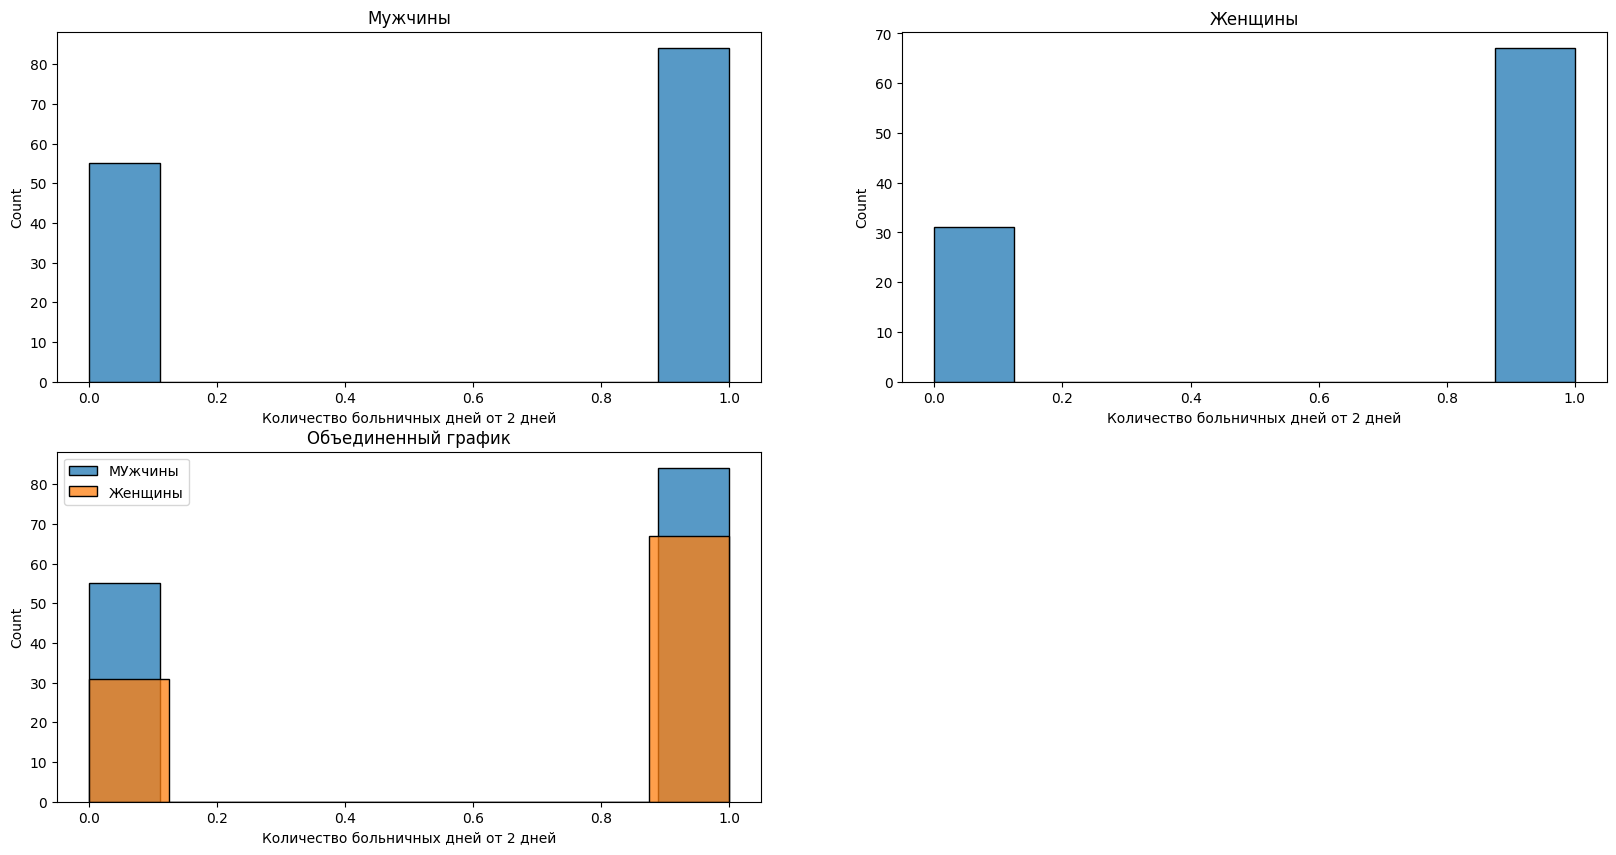

In [12]:
# визуализируем полученное разбиение
fig= plt.figure(figsize=(20,10))

fig.add_subplot(2,2, 1)
sns.histplot(hyp_1_M)
plt.title('Мужчины')

fig.add_subplot(2,2, 2)
plt.title('Женщины')
sns.histplot(hyp_1_F)

fig.add_subplot(2,2, 3)
plt.title('Объединенный график')
sns.histplot(hyp_1_M, label='МУжчины')
sns.histplot(hyp_1_F, label='Женщины')
plt.legend()

Для проверки гипотезы *"Мужчины пропускают в течение года более 2 рабочих дней (work_days) по 
болезни значимо чаще женщин."* воспользуемся статистическим **критерием Стьюдента**. Но для его применения нам необходимо выполнение трех условий   
1. Независимость выборок
2. Равенство нормированных дисперсий
3. Метрика ( среднее значение ) должна иметь нормальное распределение 

1 пункт выполняется, так как мы предполагаем, что люди брали больничный независимо друг от друга  
3 пункт выполняется согласно центральной предельной теоремы  
Для проверки пункта 2 воспользуемся F-тестом

In [13]:
# Функция, рассчитывающая статистику F-теста и соответсвующее значение p_value
def f_test(x, y):
    f = np.var(x, ddof=1)/np.var(y, ddof=1)
    dfn = x.size-1 
    dfd = y.size-1 
    p = 1-sts.f.cdf(f, dfn, dfd) 
    return f, p

In [14]:
# Результат F - теста
f, p = f_test(hyp_1_M, hyp_1_F)
print(f'Статистика F-теста = {f}, p_value={p}')

Статистика F-теста = 1.1023243534916054, p_value=0.30631703404321997


По результатам *F - теста* мы получили значение *p_value* выше чем уровень значимости ( *p=0.05* ). Это означает, что у нас есть достаточно доказательств, чтобы сказать, что две дисперсии равны. Следовательно, соблюдены все условия для применения статистического критерия Стьюдента

In [15]:
# результаты статистического критерия Стьюдента
t, p_value = sts.ttest_ind(hyp_1_F, hyp_1_M)
print(f'Статистика t-теста = {t}, p_value={p_value}')

Статистика t-теста = 1.2500883563710699, p_value=0.21251069486546614


**Вывод:** *Значение p >= 0.05, следовательно, статистически значимых различий между двумя выборками не наблюдается. Это означает, что у нас нет достаточных доказательств для того, чтобы утверждать, что мужчины пропускают в течение года более 2 рабочих дней по болезни значимо чаще женщин*

### Проверка гипотезы 2

In [16]:
# разбиваем данные на две группы: люди старше и младше 35 лет
hyp_2_1 = df.loc[(df['Возраст'] >= 35),'Количество больничных дней от 2 дней']
hyp_2_2 = df.loc[(df['Возраст'] < 35),'Количество больничных дней от 2 дней']

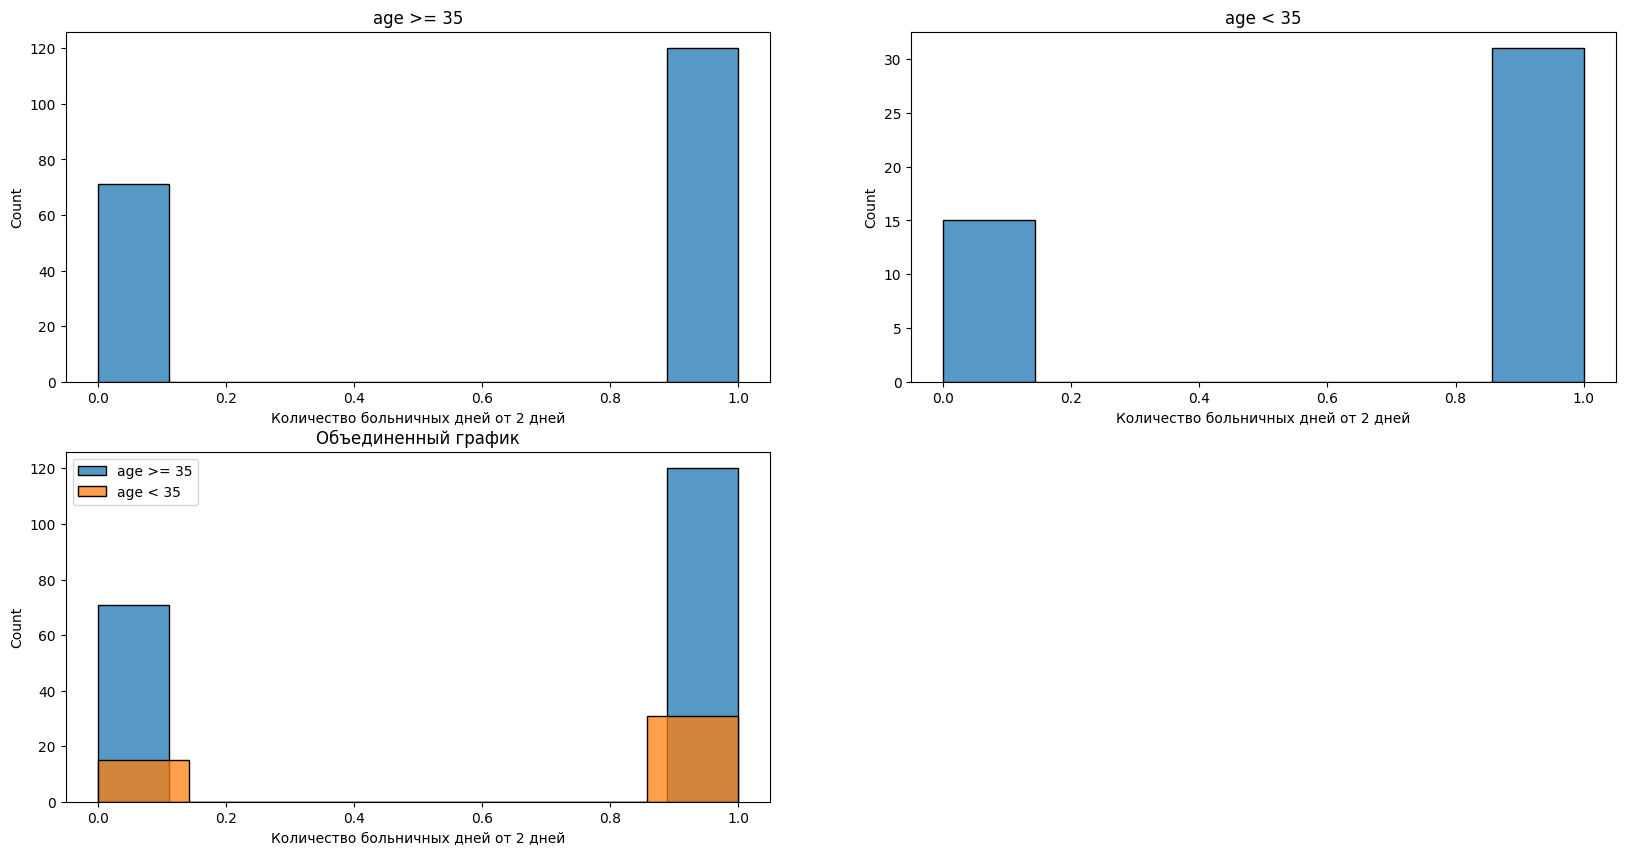

In [17]:
# визуализируем полученное разбиение
fig= plt.figure(figsize=(20,10))

fig.add_subplot(2,2, 1)
sns.histplot(hyp_2_1)
plt.title('age >= 35')

fig.add_subplot(2,2, 2)
plt.title('age < 35')
sns.histplot(hyp_2_2)

fig.add_subplot(2,2, 3)
plt.title('Объединенный график')
sns.histplot(hyp_2_1, label='age >= 35')
sns.histplot(hyp_2_2, label='age < 35')
plt.legend()

На графиках можно заметить сильный дисбаланс в данных. Результаты статистического критерий Стьюдента могут в этом случае быть искажены. Поэтому для проверки гипотезы *"Работники старше 35 лет (age) пропускают в течение года более 2 рабочих 
дней (work_days) по болезни значимо чаще своих более молодых коллег."* по мимо t - теста воспользуемся непараметрическим статистическим критерием Манна-Уитни

In [18]:
# Результат F - теста
f, p = f_test(hyp_2_1, hyp_2_2)
print(f'Статистика F-теста = {f}, p_value={p}')

Статистика F-теста = 1.0451292900381344, p_value=0.4448833906012575


По результатам *F - теста* мы также получили значение *p_value* выше чем уровень значимости ( *p=0.05* ). Это означается что у нас есть достаточно доказательств, чтобы сказать, что две дисперсии равны. Следовательно соблюдены все условия для применения статистического критерия Стьюдента

In [19]:
# результаты статистического критерия Стьюдента
t, p_value = sts.ttest_ind(hyp_2_1, hyp_2_2)
print(f'Статистика t-теста = {t}, p_value={p_value}')

Статистика t-теста = -0.5759055444593012, p_value=0.5652301272271563


In [20]:
# результаты статистического критерия Манна-Уитни
U, p_value = sts.mannwhitneyu(hyp_2_1, hyp_2_2)
print(f'Статистика t-теста = {t}, p_value={p_value}')

Статистика t-теста = -0.5759055444593012, p_value=0.5650988835953095


**Вывод:** *Значение p >= 0.05 в обоих тестах, следовательно, статистически значимых различий между двумя выборками не наблюдается. Это означает, что у нас нет достаточных доказательств для того, чтобы утверждать, что работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег*

## В какую сторону можно искать улучшения?

Можно было бы использовать дополнительные библитеки для визуализации данных для более красивых графиков, например, *plotly*   
Таким образом стало бы легче интерпретировать результаты при визуальном анализе  
Также хочу подменить, что для презентации результатов анализа я бы не использовал текущие графики